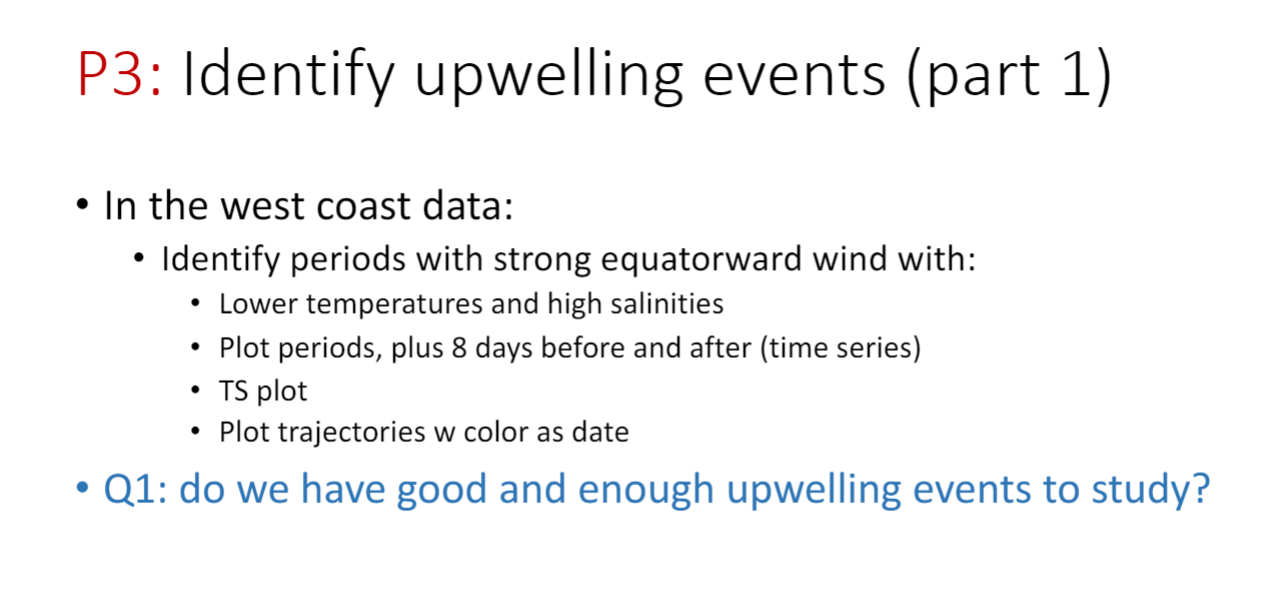

In [11]:
# import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import date
import warnings

warnings.simplefilter('ignore')

# load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr
from trajectory_plot import trajectory_plot

day_in_nanoseconds = 86400000000000


datetime_unit_var = "D" # datetime_unit argument for differentiate function

VWND_MEAN_Threshold = -5

Delta_TEMP_CTD_MEAN_Threshold = 1

Delta_SAL_CTD_MEAN_Threshold = 0.5


In [14]:

def Compile_Datasets(ddir, fn_list):

    # ddir: 'root' directory for data
    # fn_list: list of strings with the file names
    # returns: compiled list

    
    # open the first dataset
    sail = xr.open_dataset(ddir + fn_list[0])
    
    # resample so that there is one datapoint per day.
    
    # sail.resample(time="1D").interpolate("linear")
    # give the first dataset a relative ID so all datasets can be differentiated
    sail["relativeID"] = 0
    # make lists for certain variables that remain constant for each dataset. these are used later in the last two cells
    yearList = [sail["time"][0].dt.year]
    durationList = [sail["time"][len(sail["time"]) - 1] - sail["time"][0]]
    # take the actual cruise ID from the dataset attributes and put it in a new list
    realID = [int(sail.attrs["id"])]
    # add the duration back to the dataset
    sail["duration"] = durationList[0]
    
    # sail["SST_delta"] = sail["TEMP_CTD_MEAN"] - sail.sel(time = (sail["time"]-(2 * day_in_nanoseconds)), 
    #                                                      method="nearest", tolerance = (4 * 3600000000000))["TEMP_CTD_MEAN"]
    
    sail["Delta_TEMP_CTD_MEAN"] = sail["TEMP_CTD_MEAN"].differentiate("time", edge_order=1, datetime_unit="D")
    sail["Delta_SAL_CTD_MEAN"] = sail["SAL_CTD_MEAN"].differentiate("time", edge_order=1, datetime_unit="D")
    
    # repeat previous steps for other datasets that need to be combined.

    if len(fn_list) > 1:
        for i in range(1, len(fn_list)):
            
            # THE TEMP VARIABLE IN THIS LOOP MEANS TEMPORARY, NOT TEMPERATURE
            
            temp = xr.open_dataset(ddir + fn_list[i])
            temp["relativeID"] = i
            yearList.append(temp["time"][0].dt.year)
            realID.append(int(temp.attrs["id"]))
            tempDuration = temp["time"][len(temp["time"]) - 1] - temp["time"][0]
            temp["duration"] = tempDuration
            durationList.append(tempDuration)
            
            temp["Delta_TEMP_CTD_MEAN"] = temp["TEMP_CTD_MEAN"].differentiate("time", edge_order=1, datetime_unit="D")
            temp["Delta_SAL_CTD_MEAN"] = temp["SAL_CTD_MEAN"].differentiate("time", edge_order=1, datetime_unit="D")
            
            sail = xr.concat([sail, temp], dim="time")
            
            temp.close()

    # reformat dates
    sail['date'] = mdates.date2num(sail['time'].dt.date)

    # ask what variable should be plotted
    return(sail)







ddir1 = '~/Repositories/2022_SummerInternship_FarallonInstitute/saildrone_data/'  #data 2
fn_list1 = ['saildrone_west_coast_survey_2018_sd1026_JPLv5.0_8dy_20210613norep_20210613_20211116.nc', 
            'saildrone_west_coast_survey_2019_sd1047_JPLv5.0_8dy_20210613norep_20210613_20211116.nc', 
            'saildrone_west_coast_survey_2019_sd1043_JPLv5.0_8dy_20210613norep_20210613_20211116.nc']

sail = Compile_Datasets(ddir1, fn_list1)
sail


<xarray.Dataset>
Dimensions:                       (time: 305, date: 305)
Coordinates:
    trajectory                    (time) object '1026.0' '1026.0' ... 1043.0
  * time                          (time) datetime64[ns] 2018-07-08 ... 2019-0...
    ob                            (time) int64 0 1 2 3 4 5 ... 34 35 36 37 38 39
  * date                          (date) float64 1.772e+04 ... 1.811e+04
Data variables: (12/45)
    lat                           (time) float64 37.72 37.68 ... 37.94 37.91
    lon                           (time) float64 -122.8 -122.9 ... -123.3 -123.1
    SOG_MEAN                      (time) float64 1.87 2.226 ... 0.7238 0.6173
    COG_MEAN                      (time) float64 237.8 239.4 ... 93.42 101.7
    HDG_MEAN                      (time) float64 235.1 245.4 ... 97.79 96.68
    PITCH_MEAN                    (time) float64 2.4 2.503 ... -0.2021 -0.1736
    ...                            ...
    mask                          (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    sea_ice_fraction              (time) float64 nan nan nan nan ... nan nan nan
    relativeID                    (time) int64 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2
    duration                      (time) timedelta64[ns] 109 days 21:14:18.31...
    Delta_TEMP_CTD_MEAN           (time) float64 -16.97 -13.31 ... 0.1336 2.516
    Delta_SAL_CTD_MEAN            (time) float64 1.681 0.8162 ... 0.1946 -0.2652
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-08T00:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -125.3254656
    vehicle_id:                sd1026

['lat', 'lon', 'SOG_MEAN', 'COG_MEAN', 'HDG_MEAN', 'PITCH_MEAN', 'BARO_PRES_MEAN', 'TEMP_AIR_MEAN', 'RH_MEAN', 'PAR_AIR_MEAN', 'UWND_MEAN', 'VWND_MEAN', 'WWND_MEAN', 'GUST_WND_MEAN', 'TEMP_CTD_MEAN', 'TEMP_CTD_STDDEV', 'SAL_CTD_MEAN', 'CHLOR_MEAN', 'ROLL_MEAN', 'TEMP_RBR_MEAN', 'SAL_RBR_MEAN', 'TEMP_O2_RBR_MEAN', 'CDOM_MEAN', 'CHLOR_WETLABS_MEAN', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'sat_smap_sss', 'sat_anc_sss', 'sat_anc_sst', 'sat_smap_spd', 'sat_smap_high_spd', 'sat_weight', 'sat_land_fraction', 'sat_ice_fraction', 'sat_smap_sss_uncertainty', 'sat_lat', 'sat_lon', 'dist_land', 'analysed_sst', 'analysis_error', 'mask', 'sea_ice_fraction', 'relativeID', 'duration', 'Delta_TEMP_CTD_MEAN', 'Delta_SAL_CTD_MEAN']


what variable should be plotted: HDG_MEAN


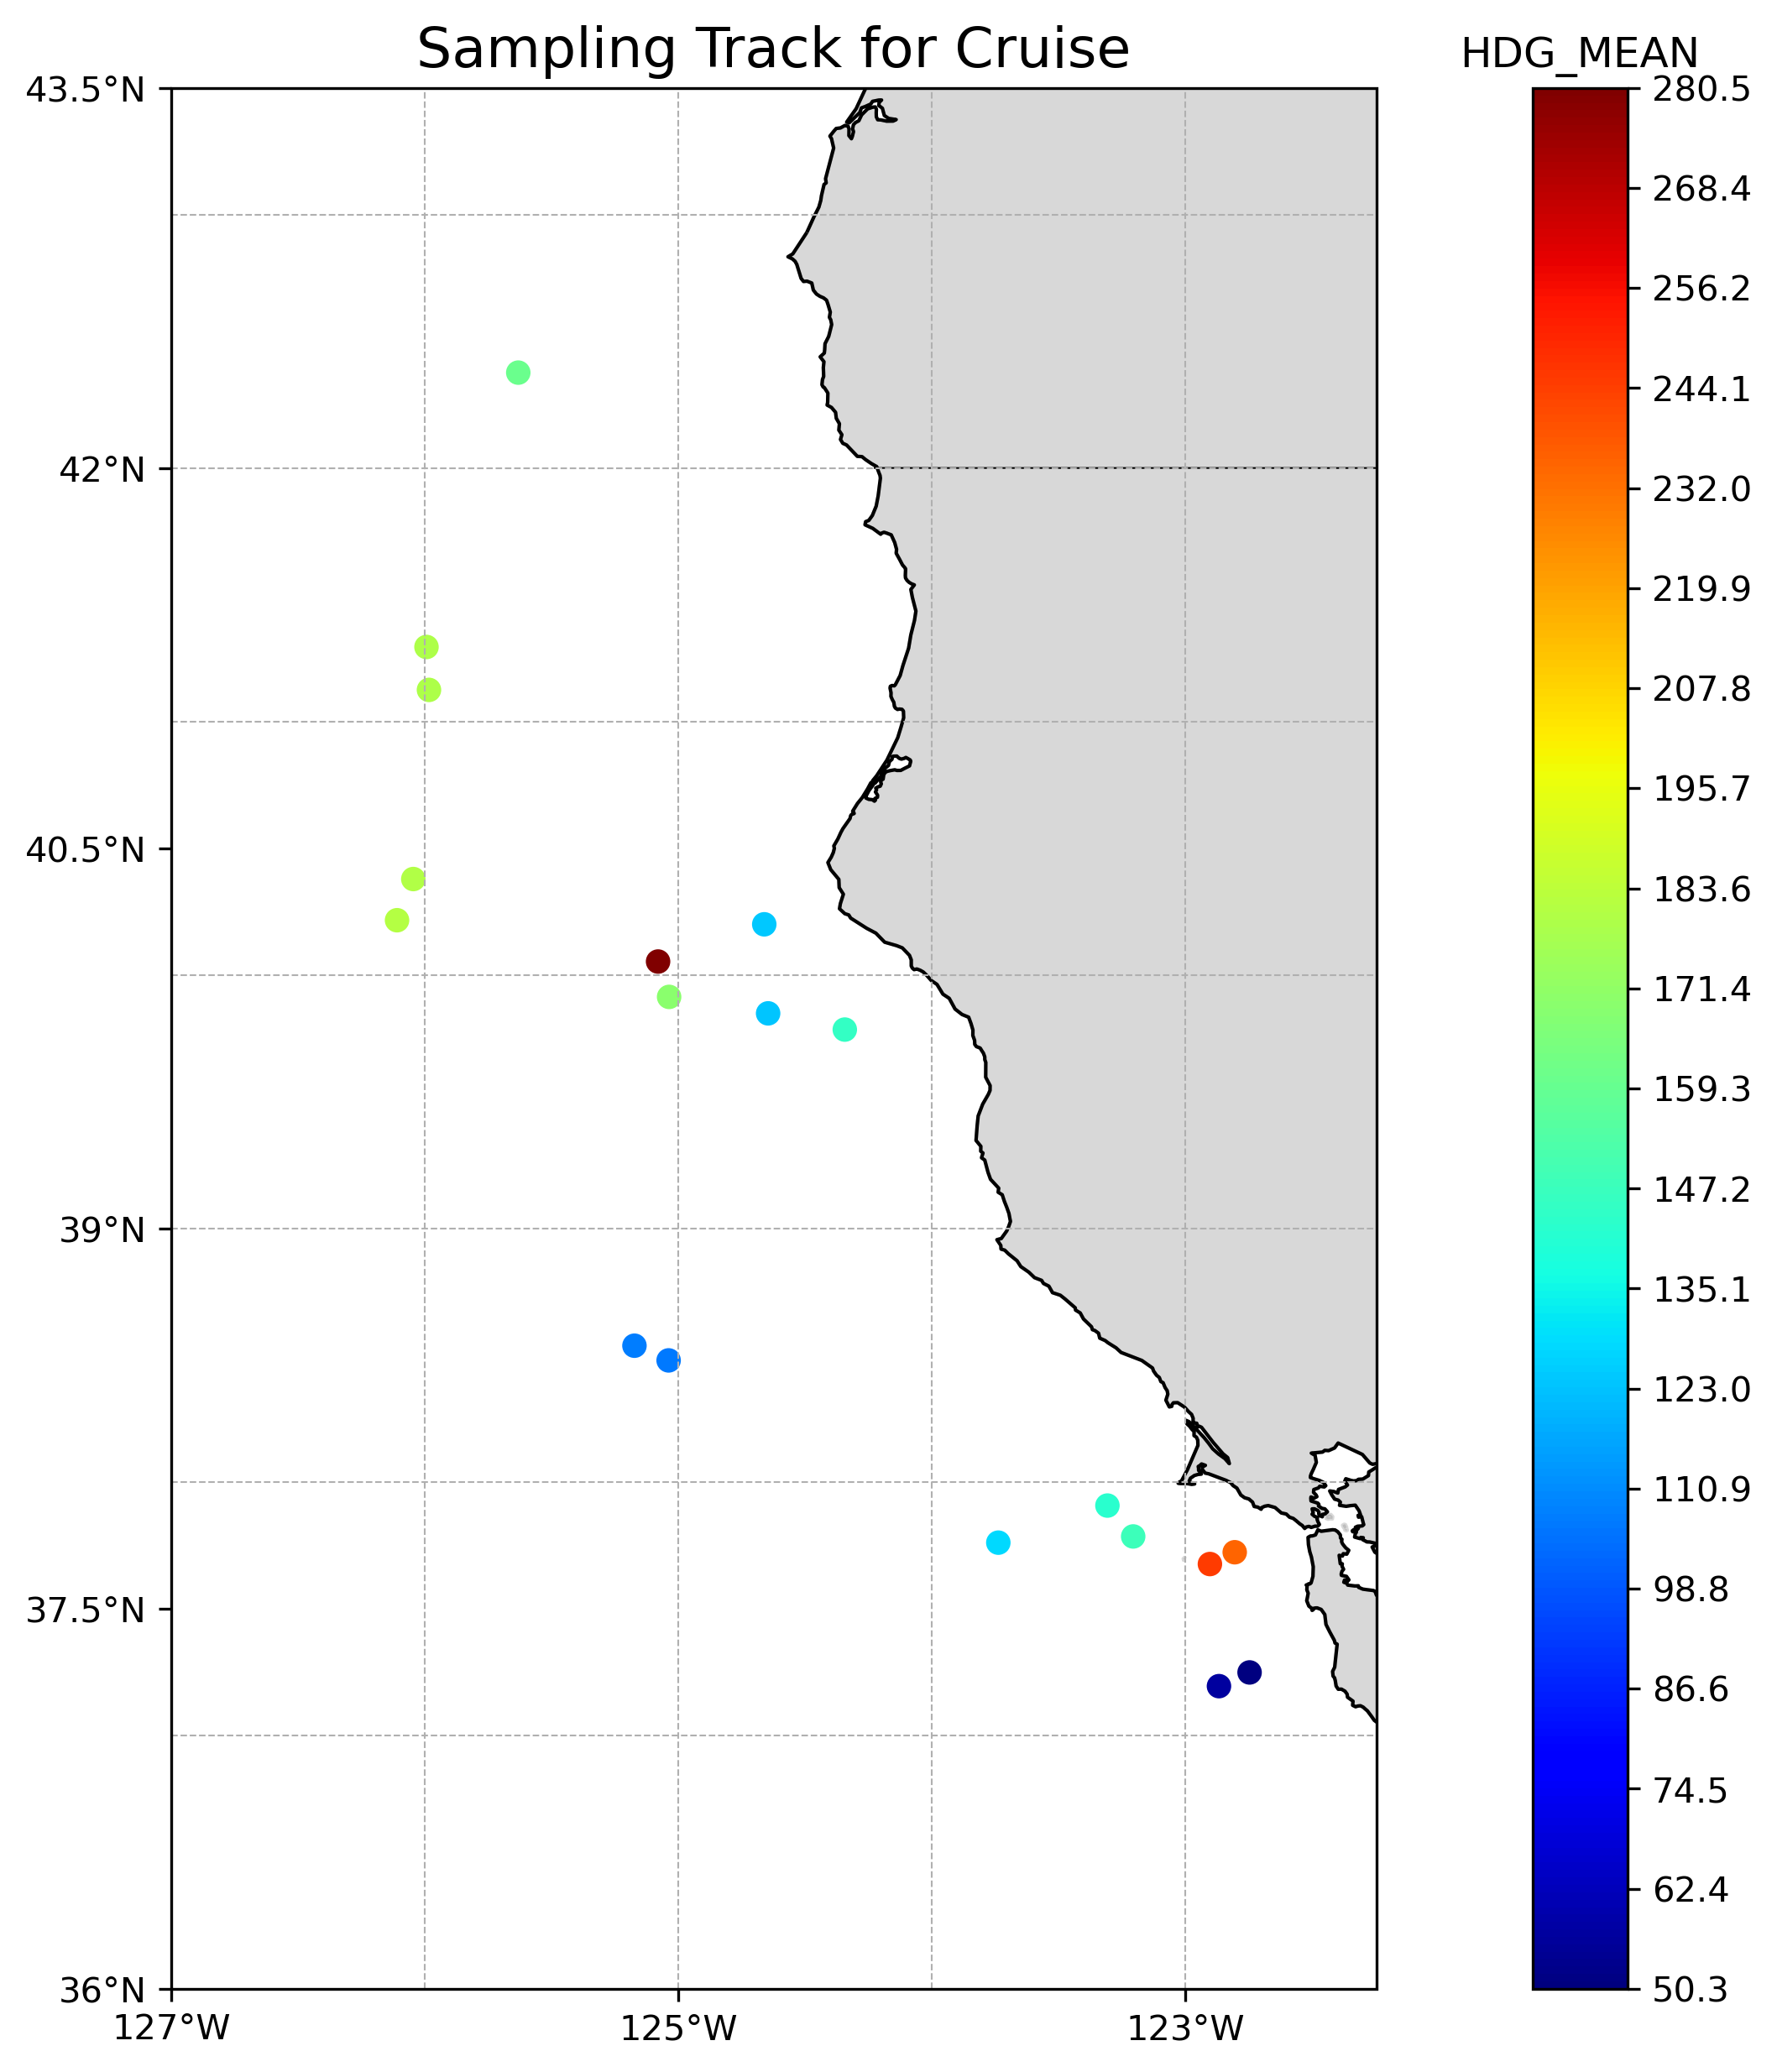

In [15]:

upwelling_data = sail.where((sail.VWND_MEAN < VWND_MEAN_Threshold) & (sail.Delta_TEMP_CTD_MEAN < Delta_TEMP_CTD_MEAN_Threshold) & 
                            (sail.Delta_SAL_CTD_MEAN > Delta_SAL_CTD_MEAN_Threshold))


# reformat dates
upwelling_data['date'] = mdates.date2num(upwelling_data['time'].dt.date)

# ask what variable should be plotted
print([i for i in upwelling_data.data_vars])
var_to_plot=input('what variable should be plotted:')

trajectory_plot(upwelling_data, var_to_plot)
